In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\Pavel\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests

init_notebook_mode(connected = True)

In [3]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%pylab inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # Dickey-Fuller Test
from statsmodels.tsa.stattools import pacf,acf # Функция расчёта частичной автокорреляции

def test_stationarity(timeseries): # Вывод результатов теста
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='t-stat')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Pavel\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot', '__version__']
`%matplotlib` prevents importing * from pylab and numpy



In [4]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [5]:
data = pd.read_csv('alchohol_sales.csv',index_col=0)
data.columns = ['Value']

In [6]:
data.head(10)

,Value
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
1992-06-01,4529
1992-07-01,4466
1992-08-01,4137
1992-09-01,4126


In [7]:
data.shape[0]

319

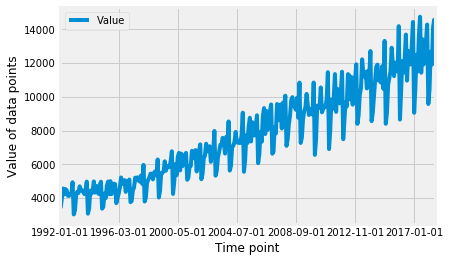

In [12]:
data.plot()
plt.ylabel('Value of data points')
plt.xlabel('Time point')
plt.show()

In [13]:
# Тест Дики-Фуллера на стационарность
test_stationarity(data['Value'])

Results of Dickey-Fuller Test:
Test Statistic                   1.140994
p-value                          0.995552
#Lags Used                      17.000000
Number of Observations Used    301.000000
Critical Value (1%)             -3.452263
Critical Value (5%)             -2.871191
Critical Value (10%)            -2.571912
dtype: float64


In [14]:
data_diff = data - data.shift(periods=1) # Вычитаем ряд из самого себя со сдвигом
data_diff.dropna(inplace=True) # Отбрасываем первую пустую строчку без значения производной

test_stationarity(data_diff['Value'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.988394
p-value                          0.001473
#Lags Used                      16.000000
Number of Observations Used    301.000000
Critical Value (1%)             -3.452263
Critical Value (5%)             -2.871191
Critical Value (10%)            -2.571912
dtype: float64


### Test Statistic < Кр порога(-4) -> ряд стационарен. Параметр d берём либо 1 либо 2

In [15]:
def Draw_autcorrelation(y,c):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(y, lags=30, ax=ax1,color=c)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(y, lags=30, ax=ax2,color=c)
    plt.show()

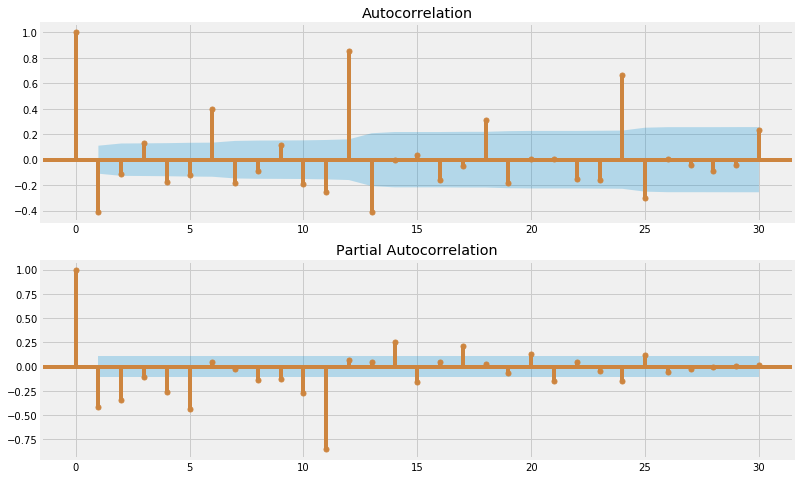

In [16]:
Draw_autcorrelation(data_diff,'peru')

In [24]:
# Define the d and q parameters to take any value between 0 and 1


d = q = range(0, 3)
# Define the p parameters to take any value between 0 and 3
p = range(12,13)
#p = range(, 7)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [25]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (12, 0, 1) x (12, 0, 1, 12)
SARIMAX: (12, 0, 1) x (12, 0, 2, 12)
SARIMAX: (12, 0, 2) x (12, 1, 0, 12)
SARIMAX: (12, 0, 2) x (12, 1, 1, 12)


In [26]:
#data partition
train_data = data.iloc[0:250]
test_data = data.iloc[250:319]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue